# Recall/MABO as a function of number of proposals included

In [57]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
from utils import calculate_iou


def get_ss_proposals(image_name : str):
    # Extract predicted boxes
    with open(os.path.join('Potholes', 'annotated-images', image_name + '_ss.json')) as f:
        pred_boxes = json.load(f)
    
    # Extract bounding box coordinates
    pred_boxes = [pred_box['bbox'] for pred_box in pred_boxes]
    
    #shuffle
    np.random.shuffle(pred_boxes)
    
    return pred_boxes
    

def bounding_box_recall_and_mabo(max_proposals, threshold=0.7, proposal_getter = get_ss_proposals):
    #n_proposals_range: list of integers, x-ticks for plot
    #threshold: float in [0,1], IOU threshold for a correct detection
    #proposal_getter: function that takes an image name such as 'img-1' and returns a list of bounding boxes in [xmin, ymin, xmax, ymax] format
    
    # Use only training data
    with open(os.path.join('Potholes', 'splits.json')) as f:
        splits = json.load(f)
    
    xml_names = splits['train']
    
    # Strip .xml
    image_names = [xml_name[:-4] for xml_name in xml_names]
    
    recalls = np.zeros(max_proposals)
    mabos = np.zeros(max_proposals)    
    images_with_this_many_proposals = np.zeros(max_proposals)
    
    # Loop through images
    for image_name in image_names:
        # Extract ground truth
        tree = ET.parse(os.path.join('Potholes', 'annotated-images', image_name + '.xml'))
        root = tree.getroot()
        GT_boxes = [
            [int(box.find("bndbox/xmin").text), 
             int(box.find("bndbox/ymin").text), 
             int(box.find("bndbox/xmax").text), 
             int(box.find("bndbox/ymax").text)]
            for box in root.iter('object')
        ]
        
        pred_boxes = proposal_getter(image_name)[:max_proposals]
    

        # Count number of images with at least a certain number of proposals
        images_with_this_many_proposals[:len(pred_boxes)] += 1
        
        
        # Precompute IOUs for all GT and predicted boxes
        iou_matrix = np.array([[calculate_iou(gt_box, pred_box) for pred_box in pred_boxes] for gt_box in GT_boxes])
        
        cummax_ious = np.maximum.accumulate(iou_matrix, axis=1)
        recalls_this_image = np.zeros(max_proposals)
        recalls_this_image[:len(pred_boxes)] = np.mean(cummax_ious > threshold, axis=0)    
        recalls_this_image[len(pred_boxes):] = recalls_this_image[len(pred_boxes)-1]
        
        mabos_this_image = np.zeros(max_proposals)
        mabos_this_image[:len(pred_boxes)] = np.mean(cummax_ious, axis=0)
        mabos_this_image[len(pred_boxes):] = mabos_this_image[len(pred_boxes)-1]
        
        recalls += recalls_this_image
        mabos += mabos_this_image
            
        
    
    mean_recalls = recalls / len(image_names)
    mean_mabos = mabos / len(image_names)
    fraction_of_images = images_with_this_many_proposals / len(image_names)
    
    return mean_recalls, mean_mabos, fraction_of_images

In [58]:
# Example usage
n_proposals_range = np.arange(10, 3000, 10)
recall, mabo, fraction_of_images = bounding_box_recall_and_mabo(3000, threshold=0.5)

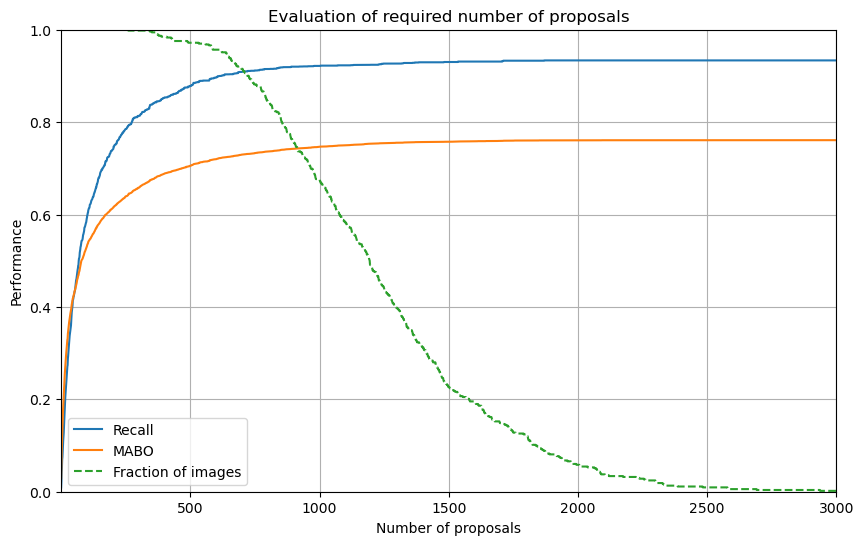

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(recall, label='Recall')
plt.plot(mabo, label='MABO')
plt.plot(fraction_of_images, '--', label='Fraction of images')

plt.grid(True)
plt.xlabel('Number of proposals')
plt.ylabel('Performance')
plt.title('Evaluation of required number of proposals')
plt.ylim(0, 1)
plt.xlim(1, 3000)

plt.legend()
plt.show()

# Verify that 'compute_t' and 'alter_box' works as expected

In [10]:
from utils import compute_t, alter_box

In [6]:
test_true_box = [0, 0, 100, 100]
test_prop_box = [5, 10, 110, 120]

t = compute_t(test_true_box, test_prop_box)
print(t)
alter_box(test_prop_box, t)



(-0.047619047619047616, -0.09090909090909091, -0.048790164169432056, -0.0953101798043249)


(0.0, 0.0, 100.0, 100.0)

# Edge boxes

In [1]:
from module.proposal_generators.edge_boxes import return_edge_box_proposals
from module.proposal_generators.store_all import store_all_proposals

In [17]:
#takes about 14 minutes to run on my machine (Ø)
#store_all_proposals(return_edge_box_proposals, 'eb', max_boxes=3000, min_score=0.01, Canny_lower_threshold=50, Canny_upper_threshold=150)

Processing Images: 100%|██████████| 665/665 [14:04<00:00,  1.27s/image]


In [63]:
def get_eb_proposals(image_name : str):
    
    # Extract predicted boxes
    with open(os.path.join('Potholes', 'annotated-images', image_name + '_eb.json')) as f:
        pred_boxes = json.load(f)
    
    # Extract bounding box coordinates
    pred_boxes = [pred_box['bbox'] for pred_box in pred_boxes]
    
    #shuffle
    np.random.shuffle(pred_boxes)
    
    return pred_boxes

In [64]:
import numpy as np
max_proposals = 3000
recall, mabo, fraction_of_images = bounding_box_recall_and_mabo(max_proposals, proposal_getter=get_eb_proposals, threshold=0.5)

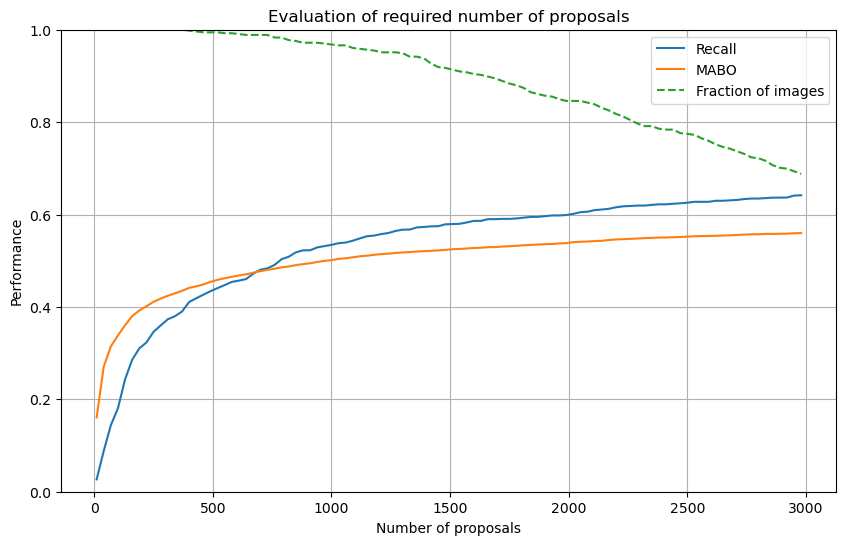

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(n_proposals_range, [recall[k] for k in n_proposals_range], label='Recall')
plt.plot(n_proposals_range, [mabo[k] for k in n_proposals_range], label='MABO')
plt.plot(n_proposals_range, [fraction_of_images[k] for k in n_proposals_range], '--', label='Fraction of images')

plt.grid(True)
plt.xlabel('Number of proposals')
plt.ylabel('Performance')
plt.title('Evaluation of required number of proposals')
plt.ylim(0, 1)

plt.legend()
plt.show()

# Non maximum supression

In [2]:
from module.processing.non_maximum_suppression import non_maximum_suppression

In [9]:
import numpy as np
from utils import calculate_iou
test_boxes = [
    [0, 0, 100, 100],
    [0, 0, 110, 110],
    [0, 0, 120, 120],
    [115, 115, 125, 125],
    ]

pairwise_iou = np.array([[calculate_iou(box1, box2) for box2 in test_boxes] for box1 in test_boxes])
print(pairwise_iou)


ps = [0.8, 0.9, 0.5, 0.2]

non_maximum_suppression(list(zip(test_boxes, ps)), 0.84)
# when looking at the most likely box (box 2), box 3 will be discarded because iou(box2, box3) = 0.8403 > 0.84
# Then we will inspect box 1, and nothing will be discarded.
# Then we will inspect box 4, and nothing will be discarded.

# So the output should be [box2, box1, box4] with corresponding probabilities [0.9, 0.8, 0.2]

[[1.         0.82644628 0.69444444 0.        ]
 [0.82644628 1.         0.84027778 0.        ]
 [0.69444444 0.84027778 1.         0.00172712]
 [0.         0.         0.00172712 1.        ]]


[([0, 0, 110, 110], 0.9), ([0, 0, 100, 100], 0.8), ([115, 115, 125, 125], 0.2)]

# Visualize some edge boxes and SS boxes

Number of GT boxes: 2
Number of SS proposals: 745
Number of EB proposals: 3000


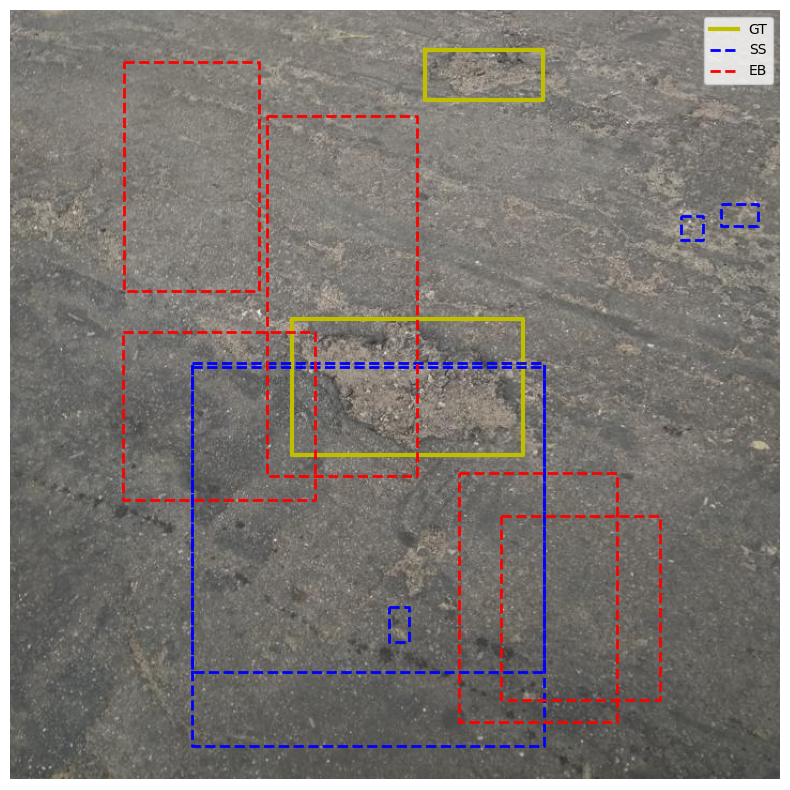

In [56]:
from utils import parse_xml
import os
import random

img = 'img-9'

with open(os.path.join('Potholes', 'annotated-images', img + '.xml')) as f:
    GT_boxes = parse_xml(f)

print(f'Number of GT boxes: {len(GT_boxes)}')

SS_boxes = get_ss_proposals(img)
EB_boxes = get_eb_proposals(img)
print(f'Number of SS proposals: {len(SS_boxes)}')
print(f'Number of EB proposals: {len(EB_boxes)}')

image = plt.imread(os.path.join('Potholes', 'annotated-images', img + '.jpg'))

#show image
plt.figure(figsize=(10, 10))
plt.imshow(image)


# Plot GT boxes
for box in GT_boxes:
    plt.plot([box[0], box[2], box[2], box[0], box[0]], [box[1], box[1], box[3], box[3], box[1]], 'y', linewidth=3, label='GT')

# Plot SS boxes
for box in random.sample(SS_boxes, 5):
    plt.plot([box[0], box[2], box[2], box[0], box[0]], [box[1], box[1], box[3], box[3], box[1]], 'b--', linewidth=2, label='SS')

# Plot EB boxes
for box in random.sample(EB_boxes, 5):
    plt.plot([box[0], box[2], box[2], box[0], box[0]], [box[1], box[1], box[3], box[3], box[1]], 'r--', linewidth=2, label='EB')

# Remove duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.axis('off')

plt.show()

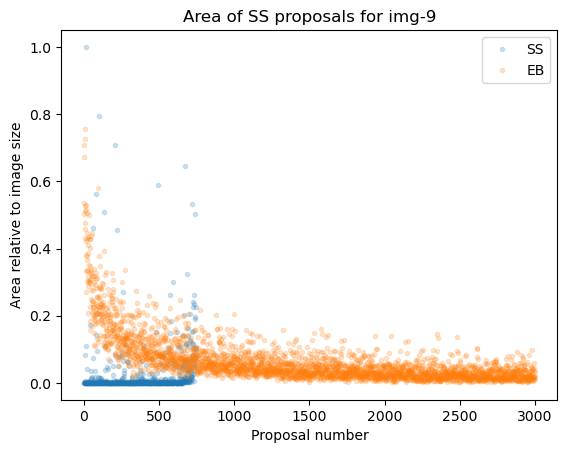

In [48]:
def Area(box, width, height):
    return (box[2] - box[0])/width * (box[3] - box[1])/height

ss_areas = [Area(box, *image.shape[:2]) for box in SS_boxes]
eb_areas = [Area(box, *image.shape[:2]) for box in EB_boxes]

plt.plot(ss_areas, '.', label = 'SS', alpha = 0.2)
plt.plot(eb_areas, '.', label = 'EB', alpha = 0.2)
plt.xlabel('Proposal number')
plt.ylabel('Area relative to image size')
plt.title(f'Area of SS proposals for {img}')
plt.legend()
plt.show()


# Investigate true area distribution for box selection
As we've just seen, the edge boxes returned by SS and EB are not arbitrarily ordered. In capping them, we should try to select the best ones.

A naive way to do that might be to select those with the most 'likely' area with highest probability.

Approach
- Find the area of every GT box in the train set
- Use KDE to make that list into a continuous distribution (in fact, I am doing KDE on log-transformed data to avoid the fact that the data is bounded below at 0)
- Upon seeing a new box, estimate its likelihood based on this KDE (again, be aware of log transform and chain rule adjustment)
- When selecting boxes (whether at test time or for Recall/MABO plots), select them randomly with their probability as weight


In [96]:
def parse_xml_with_dims(xml_file):
    #input: xml_file object
    #output: list of bounding boxes for potholes in [xmin, ymin, xmax, ymax] format
    
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # List to hold bounding boxes for all potholes
    pothole_bboxes = []

    # Get all bounding boxes from the XML
    for obj in root.findall('object'):
        if obj.find('name').text == 'pothole':
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            pothole_bboxes.append((xmin, ymin, xmax, ymax))
            
    width = int(root.find('size').find('width').text)
    height = int(root.find('size').find('height').text)

    return pothole_bboxes, (width, height)

# Inspect distribution of GT areas
def get_all_gt_boxes_with_dims():
    with open(os.path.join('Potholes', 'splits.json')) as f:
        splits = json.load(f)
    
    xml_names = splits['train']
    GT_boxes = []
    for xml_name in xml_names:
        with open(os.path.join('Potholes', 'annotated-images', xml_name)) as f:
            boxes, (width, height) = parse_xml_with_dims(f)
            GT_boxes += [(box, (width, height)) for box in boxes]
        
    
    return GT_boxes

GT_boxes = get_all_gt_boxes_with_dims()

GT_areas = np.array([Area(box, width, height) for (box, (width, height)) in GT_boxes])

epsilon = 1e-10
log_GT_areas = np.log(GT_areas + epsilon)


from scipy.stats import gaussian_kde

kde = gaussian_kde(log_GT_areas)



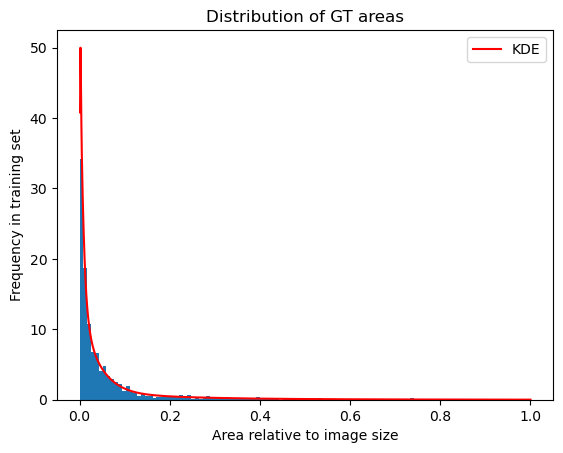

In [101]:
plt.hist(GT_areas, bins=100, density=True)
plt.xlabel('Area relative to image size')
plt.ylabel('Frequency in training set')
plt.title('Distribution of GT areas')

xs = np.linspace(1e-3, 1, 1000)
log_xs = np.log(xs + epsilon)
density = kde(log_xs) / xs #chain rule adjustment
plt.plot(xs, density, label='KDE', color='r')

plt.legend()

plt.show()

# Understand our EfficientNet alterations

In [1]:
import timm
model = timm.create_model('efficientnet_b5', pretrained=True, num_classes=1)

In [2]:
#list model layers and parameter shapes
for name, param in model.named_parameters():
    print(name, param.shape)

conv_stem.weight torch.Size([48, 3, 3, 3])
bn1.weight torch.Size([48])
bn1.bias torch.Size([48])
blocks.0.0.conv_dw.weight torch.Size([48, 1, 3, 3])
blocks.0.0.bn1.weight torch.Size([48])
blocks.0.0.bn1.bias torch.Size([48])
blocks.0.0.se.conv_reduce.weight torch.Size([12, 48, 1, 1])
blocks.0.0.se.conv_reduce.bias torch.Size([12])
blocks.0.0.se.conv_expand.weight torch.Size([48, 12, 1, 1])
blocks.0.0.se.conv_expand.bias torch.Size([48])
blocks.0.0.conv_pw.weight torch.Size([24, 48, 1, 1])
blocks.0.0.bn2.weight torch.Size([24])
blocks.0.0.bn2.bias torch.Size([24])
blocks.0.1.conv_dw.weight torch.Size([24, 1, 3, 3])
blocks.0.1.bn1.weight torch.Size([24])
blocks.0.1.bn1.bias torch.Size([24])
blocks.0.1.se.conv_reduce.weight torch.Size([6, 24, 1, 1])
blocks.0.1.se.conv_reduce.bias torch.Size([6])
blocks.0.1.se.conv_expand.weight torch.Size([24, 6, 1, 1])
blocks.0.1.se.conv_expand.bias torch.Size([24])
blocks.0.1.conv_pw.weight torch.Size([24, 24, 1, 1])
blocks.0.1.bn2.weight torch.Size([24

In [3]:
#just to verify that forward_features takes x all the way through the network, and returns the output of the last layer before the classification head
import inspect
source_code = inspect.getsource(model.forward_features)
print(source_code)

    def forward_features(self, x):
        x = self.conv_stem(x)
        x = self.bn1(x)
        if self.grad_checkpointing and not torch.jit.is_scripting():
            x = checkpoint_seq(self.blocks, x, flatten=True)
        else:
            x = self.blocks(x)
        x = self.conv_head(x)
        x = self.bn2(x)
        return x



In [4]:
# see what regular forward does
print(inspect.getsource(model.forward))

print()

print(inspect.getsource(model.forward_head))




    def forward(self, x):
        x = self.forward_features(x)
        x = self.forward_head(x)
        return x


    def forward_head(self, x, pre_logits: bool = False):
        x = self.global_pool(x)
        if self.drop_rate > 0.:
            x = F.dropout(x, p=self.drop_rate, training=self.training)
        return x if pre_logits else self.classifier(x)



In [5]:
import torch
input = torch.randn(1, 3, 224, 224)


print(model.global_pool(input))

print(input.mean([2, 3]))

tensor([[-0.0003, -0.0023,  0.0051]])
tensor([[-0.0003, -0.0023,  0.0051]])


In [6]:
features = model.forward_features(input)
print(features.shape)
model.classifier.in_features

torch.Size([1, 2048, 7, 7])


2048

In [7]:
from module.models.efficientnet import EfficientNetWithBBox

model2 = EfficientNetWithBBox('efficientnet_b5', pretrained=True, num_classes=1)

In [8]:
model2(input)

(tensor([[0.1723]], grad_fn=<AddmmBackward0>),
 tensor([[-0.1701, -0.0488, -0.1338,  0.2517]], grad_fn=<AddmmBackward0>))

# Run trained model

In [34]:
from module.models.efficientnet import EfficientNetWithBBox
import torch
import matplotlib.pyplot as plt
import os
import json
import random
from utils import parse_xml, compute_t, alter_box
from PIL import Image
import numpy as np

In [35]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model
model_path = "Trained_models/model_20241110_1518.pth"
model = EfficientNetWithBBox('efficientnet_b5', pretrained=False, num_classes=1)
model.load_state_dict(torch.load(model_path, map_location=device))

/var/folders/qd/8flc351506n6h1qrb8zdgbl40000gn/T/ipykernel_61583/473102869.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, m

<All keys matched successfully>

In [36]:
# small data loader to avoid memory issues

names = [f"img-{i}" for i in range(1, 11)]

def load_data(names):
    for name in names:
        
        image = Image.open(os.path.join('Potholes', 'annotated-images', name + '.jpg'))
        
        with open(os.path.join('Potholes', 'annotated-images', name + '.xml')) as f:
            GT_boxes = parse_xml(f)
        
        # read proposals
        with open(os.path.join('Potholes', 'annotated-images', name + '_ss.json')) as f:
            SS_boxes = json.load(f)
            SS_boxes = [box['bbox'] for box in SS_boxes]    
        
        yield image, GT_boxes, SS_boxes

In [ ]:
gen = load_data(names)

In [61]:
image, GT_boxes, SS_boxes = next(gen)

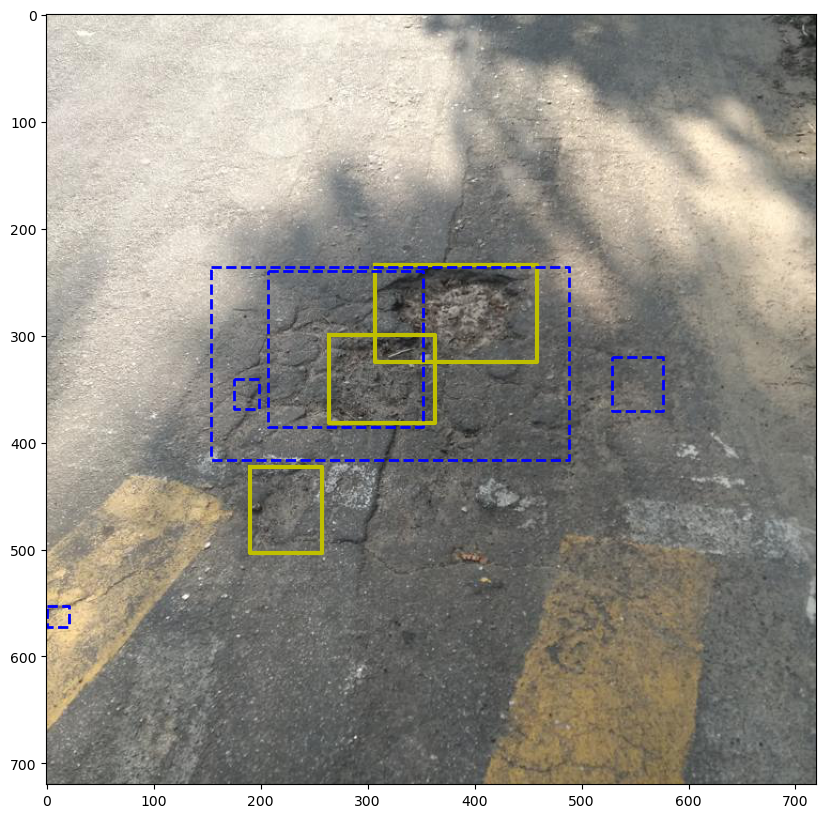

In [62]:
#show image
plt.figure(figsize=(10, 10))
plt.imshow(image)

# Plot GT boxes
for box in GT_boxes:
    plt.plot([box[0], box[2], box[2], box[0], box[0]], [box[1], box[1], box[3], box[3], box[1]], 'y', linewidth=3, label='GT')
    
# Plot SS boxes
for box in random.sample(SS_boxes, 5):
    plt.plot([box[0], box[2], box[2], box[0], box[0]], [box[1], box[1], box[3], box[3], box[1]], 'b--', linewidth=2, label='SS')

In [63]:
def plot_box(box, **plot_args):
    plt.plot([box[0], box[2], box[2], box[0], box[0]], [box[1], box[1], box[3], box[3], box[1]], **plot_args)

Probability of pothole: 0.9999631643295288
t values: [0.0017381012439727783, 0.018958680331707, 0.02301792800426483, 0.026973746716976166]
Probability of pothole: 0.5758852362632751
t values: [-0.05328141897916794, 0.006274791434407234, 0.039765506982803345, -0.011958986520767212]
Probability of pothole: 0.999626636505127
t values: [0.003679569810628891, 0.011090032756328583, 0.027676846832036972, 0.03632098808884621]
Probability of pothole: 2.4094773834804073e-05
t values: [-0.12414335459470749, -0.16192814707756042, -0.12139721214771271, -0.17787516117095947]
Probability of pothole: 1.8221511709271e-05
t values: [0.08778777718544006, 0.041494034230709076, -0.006478391587734222, 0.08414682000875473]
Probability of pothole: 2.776408337012981e-06
t values: [0.09570904076099396, 0.1531529724597931, 0.04322736710309982, -0.300017386674881]
Probability of pothole: 8.100671402644366e-05
t values: [-0.043918393552303314, -0.10522009432315826, 0.22483882308006287, 0.003800461068749428]
Probab

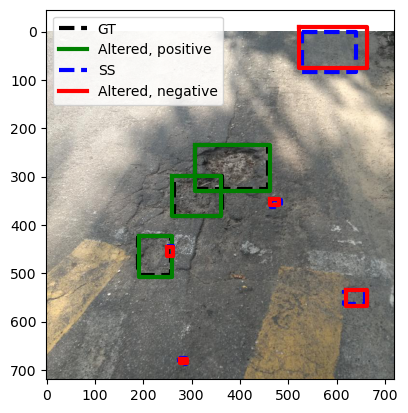

In [64]:
dim = (128, 128)

plt.imshow(image)

GT_boxes_and_some_proposals = [(box, 'GT') for box in GT_boxes] + [(box, 'SS') for box in random.sample(SS_boxes, 5)]

for box, type in GT_boxes_and_some_proposals:
    color = 'b' if type == 'SS' else 'k'
    plot_box(box, color = color, linewidth=3, label=type, linestyle = '--')
    
    crop = image.crop(box)
    resized_crop = crop.resize(dim, Image.LANCZOS)
    tensor_crop = torch.tensor(np.array(resized_crop), dtype=torch.float32).permute(2, 0, 1) / 255.0 
    tensor_crop = tensor_crop.unsqueeze(0).to(device)
    
    class_prob_logit, t_values = model(tensor_crop)
    
    class_prob = torch.sigmoid(class_prob_logit)
    t_values = t_values.squeeze().tolist()
    
    print(f'Probability of pothole: {class_prob.item()}')
    print(f't values: {t_values}')

    # Alter the box
    altered_box = alter_box(box, t_values)
    color = 'g' if class_prob > 0.5 else 'r'
    label = f'Altered, {"positive" if class_prob > 0.5 else "negative"}'
    plot_box(altered_box, color = color, linewidth=3, label=label)

# Remove duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
    
plt.show()